In [1]:
import pandas as pd
import torch
from itertools import zip_longest

# local imports
from src.dataset import load_dataset
from src.train   import train_model
from src.models  import ATISMultiTaskModel as Model
from src.models  import SentenceEncoder as Encoder
from src.utils   import plot_metrics, plot_comparison_metrics_subplot
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Task 0: Data

In [2]:
train_ds, val_ds = load_dataset('data')

In [3]:

'''Demonstration purpose only'''

record = train_ds[5]
gt = record['gt']

words      = gt[1].split()

# pull out the first 12 of each
tokens     = record['input_ids'].tolist()[:12]
entities   = gt[2][:12]
entity_ids = record['slot_labels'].tolist()[:12] # type: ignore
mask       = record['attention_mask'].tolist()[:12]

# zip them together and print a table
header = f"{'Word':^15s} | {'TokenID':^7s} | {'Entity':^12s} | {'EntID':^6s} | {'Mask':^4s}"
print(header)
print("-" * len(header))
for w, t, e, eid, m in zip_longest(words, tokens, entities, entity_ids, mask, fillvalue="[PAD]"):
    print(f"{w:^15s} | {str(t):^7s} | {e:^12s} | {str(eid):^6s} | {str(m):^3s}")

     Word       | TokenID |    Entity    | EntID  | Mask
--------------------------------------------------------
       i        |  1045   |      X       |   2    |  1 
     need       |  2342   |      X       |   2    |  1 
       a        |  1037   |      X       |   2    |  1 
    flight      |  3462   |      X       |   2    |  1 
   tomorrow     |  4826   |   DateTime   |   6    |  1 
     from       |  2013   |      X       |   2    |  1 
   columbus     |  8912   |   Location   |   4    |  1 
      to        |  2000   |      X       |   2    |  1 
  minneapolis   |  11334  |   Location   |   4    |  1 
     [PAD]      |    0    |    [PAD]     |   0    |  0 
     [PAD]      |    0    |    [PAD]     |   0    |  0 
     [PAD]      |    0    |    [PAD]     |   0    |  0 


##### Dataset Overview

This project uses a **curated subset** of the Airline Travel Information System (ATIS) corpus. Each example consists of a user’s flight-related utterance, annotated with:

- **Intent**: the user’s overall goal (e.g. searching for flights, checking fares).  
- **Entities**: token-level labels indicating semantic categories (e.g. cities, times).

---

##### Example Record

```json
{
  "text":    "i need a flight tomorrow from columbus to minneapolis",
  "entities":["X","X","X","X","DateTime","X","Location","X","Location"],
  "intent":  "Flight"
}
```
---


Here:

- **text**: raw user utterance  
- **entities**: one tag per token ('X' = no entity)  
- **intent**: high-level query category  
> **Note:** `X` corresponds to 'other (uninteresting)' category.

##### Modeling Tasks

1. Intent Classification 
   - Build a classifier that takes an utterance and predicts its **intent** label.
   - 8 intent classes ('Fare', 'Meal', 'Capacity', 'FlightInfo', 'Location', 'Flight', 'Restriction', 'Schedule')

2. Named Entity Recognition (NER) 
   - Perform token-level labeling to assign each word in the utterance one of the **entity** tags.
   - 9 Entities ('X', 'Airline', 'Meal', 'Location', 'Modifier', 'DateTime', 'FlightDetails', 'Identifier', 'Price')


##### Dataset
The data set consists of below keys
- **input_ids**: the text tokenized using bert tokenizer consisting of a vocab of size 30522
- **attention_mask**: 1 where word valid 0 for padding
- **intent_label**: label encoded intent
- **slot_labels**: label encoded entities / slot

All sentences are padded to `100` while 0 represents padding for all positions except intent_label
> **Assumption**: BERT tokenizer adds special tokens ([CLS], [SEP]) which has been disabled and a naive `one-entity-per-word` is assumed. 

Note: "slot" and "entity" are synonymous in this codebase (I inherited 'slot' from the original data).


For additional filtering steps and exploratory data analysis, please see `notebooks/dataset.ipynb`.

## Task 1: Sentence Transformer Implementation

Below is a Transformer encoder similar to BERT’s backbone, plus a thin wrapper for sentence-level embeddings. it consists of 

- **Token Embedding** – maps input token IDs to dense vectors.
- **Positional Encoding** – adds sinusoidal position information.
- **Transformer Encoder Stack** – N identical layers of multi-head attention + feed-forward.
- **Sentence Encoder** – wraps the backbone and applies mean-pooling to produce fixed-size sentence vectors.


```Text
SentenceEncoder
└─ backbone: CustomEncoder
   ├─ Embedding (30,522 → <d_model>)
   ├─ PositionalEncoding (dropout=0.1)
   └─ TransformerEncoder (6× layers)
      └─ TransformerEncoderLayer (repeated 6×)
         ├─ MultiHeadAttention (<d_model> → <d_model>)
         ├─ FeedForward (<d_model> → 2048 → <d_model>)
         ├─ LayerNorm (ϵ=1e-5) ×2
         └─ Dropout (p=0.1) ×2
```

In [4]:
'''Demonstration purpose only'''

dims = [64, 32, 16]

input_ids      = record['input_ids'].unsqueeze(0).to(device)
attention_mask = record['attention_mask'].unsqueeze(0).to(device)

for d in dims:
    enc =  Encoder("custom", d).to(device)
    with torch.no_grad():
        e = enc(input_ids, attention_mask)
    
    # free v-ram/ram memory
    del enc
        
    print(f"{d}-dim encoder output shape: {e.shape}")

64-dim encoder output shape: torch.Size([1, 64])
32-dim encoder output shape: torch.Size([1, 32])
16-dim encoder output shape: torch.Size([1, 16])


## Task 2: Multi-Task Learning Expansion 

Below is a model that extends upon the earlier encoder backbone. Below are the additions 

- **intent_head**:
  - A simple feed-forward network to project the latent to intent.
  - Takes the pooled sentence embedding i.e the mean‐over‐tokens.
  - Shape (batch, d_model)
  - Sentence level Classification 
- **slot_head** 
  - To further contextualize token representations before labeling A `transformer block` to project the latent to entities/slot.
  - Takes the last layer hidden states from the backbone.
  - Shape (batch, seq_len, num_slots)
  - token-level classification


#### Loss
```python
loss_intent = CE(intent_logits, intent_labels)
loss_slot   = CE(slot_logits.view(-1, num_slots),
                 slot_labels.view(-1))
loss = (λ1 * loss_intent) + (λ2 * loss_slot)
```
Here λ1 and λ2 are relative weights, Where `λ2 > λ1` to prioritize improving token-level performance.


```Text

MultiTaskModel
└─ encoder: SentenceEncoder
|  └─ backbone: CustomEncoder
|     ├─ Embedding (30,522 → <d_model>)
|     ├─ PositionalEncoding (dropout=0.1)
|     └─ TransformerEncoder (6× layers)
|        └─ TransformerEncoderLayer (repeated 6×)
|           ├─ MultiHeadAttention (<d_model> → <d_model>)
|           ├─ FeedForward (<d_model> → 2048 → <d_model>)
|           ├─ LayerNorm (ϵ=1e-5) ×2
|           └─ Dropout (p=0.1) ×2
|
└─ intent_head: Linear(<d_model> → 8)
└─ slot_head:   Transformer
    ├─ TransformerEncoderLayer
    │  ├─ MultiHeadAttention (<d_model> → <d_model>)
    │  ├─ FeedForward (<d_model> → 2048 → <d_model>)
    │  ├─ LayerNorm (ϵ=1e-5) ×2
    │  └─ Dropout (p=0.2) ×2
    │
    └─ Linear (<d_model> → 10)

```

### Task 3: Training Considerations 

##### **Scenario 1:** If the entire network should be frozen (no training)
**When to use:** 
- Zero-shot/inference only, no labeled data or compute budget for fine-tuning.
- The backbone pre-trained for this specific dataset.

**Advantages** 
- Removes the over head of training, works out of the box.
- No compute budget needed to training.
  
**Disadvantages** 
- Cannot adapt to domain shifts.
- No capacity to correct systematic errors of the pre-trained model for specific domain.
- Very limited use cases.


##### **Scenario 2:** If only the transformer backbone should be frozen (Freeze backbone, train only task heads).
**When to use:** 
- In most of the cases a foundational model / general purpose pre-trained model is used as a backbone.

**Advantages** 
- Removes the over head of training the massive backbone, only train the smaller projection layers.
- Has more flexibility to adapt to different task as long the dataset remains similar.
- Retains general language understanding of pre-trained backbone.  
- Enables faster experiments on head architectures.

**Disadvantages** 
- Cannot refine backbone to domain-specific patterns, accuracy may platue soon. 
- Limited capabilities for domain/task specific adaptation.
- May under-fit if head capacity alone is insufficient to correct pre-trained biases

##### **Scenario 3:** If only one of the task-specific heads (either for Task A or Task B) should be frozen.
**When to use:** 
- Strong multi-task imbalance: one loss reaches plateau long before the other.
- After reaching certain level of accuracy either of the heads can be frozen to focus more on the other task. 
- An training loop can be written that only trains the head with below threshold accuracy

**Advantages** 
- Focuses remaining capacity on the still-improving task.  
- May help focusing / simplifying multi task learning.


**Disadvantages**
- Will be very limited in capabilities for multi task, always good in one
- Introduces training complexity (dynamic freezing/unfreezing logic). 
- Can destabilize gradients, requires careful scheduling and possibly gradient clipping.
- Personally I don't see any reason to freeze heads, as this may free up gpu memory by a little but that portion will not be occupied for the current training. 


##### **Why transfer learning?**  
For tasks like these transfer learning makes a lot of sense as learning the embeddings from scratch will be very tough and time consuming. Also for larger corpus of data very tough. A sensible solution is have a pre-trained model as a backbone and then fine-tune the whole network if the task is very different or data is domain specific or transfer-learn last few layers or add additional heads to the backbone.

**Choice of pre-trained model:** 
- **BERT-base** (12 layers, 768 d_model): widely used encoder-only model, bi-directional attention, trained on BookCorpus + Wikipedia.

**Freeze/unfreeze strategy:**  
- **Option A (full fine-tune):** 
  - Unfreeze all layers 
  - Max adaptation when domain diverges.  
- **Option B (head-only):** 
  - Freeze backbone and train only heads 
  - Fastest and useful when compute-constrained.  
- **Option C (gradual unfreeze):** 
  - Start head-only
  - Then unfreeze last 2–4 encoder layers after head convergence.

**Rationale:**  
- Full fine-tune yields best performance when you have labels & VRAM.  
- Head-only reduces GPU memory and training time, good for prototyping.  
- Gradual unfreeze balances stability and adaptivity.

Below image is the result of training on current tasks and data. 
Three strategies are demonstrated
- Fine-tuning Pre-trained BERT (Best Performance)
- Training a custom model from scratch 
- Transfer-learning BERT. Backbone frozen only the training head learns

The training logs can be found in Appendix

![alt text](./plots/overall_comparision.png "Metrics")



### Task 4: Training Loop Implementation (BONUS)

All code lives under `src/train`, but here’s the pseudo-code and explanation of each piece.

##### 1. Data Preparation

- **Inputs**  
  - `input_ids` (B, L)  
  - `attention_mask` (B, L)  
  - `intent_label` (B,)  
  - `slot_labels` (B, L)  
- **Padding**  
  - Sentences padded to L=100.  
  - When computing slot loss, we only include positions where `attention_mask == 1`.

##### 2. Training loop: 

```python

for epoch in range(epochs):
    optimizer.zero_grad()
    # put data to device
    input_ids      = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    intent_labels  = batch["intent_label"].to(device)
    slot_labels    = batch["slot_labels"].to(device)

    # forward pass
    logits_i, logits_s = model(input_ids, attention_mask)
    
    # flatten and mask slot predictions
    intent_pair = (logits_i, intent_labels)
    flat_mask   = attention_mask.view(-1) == 1
    slot_pair   = (
        logits_s.view(-1, logits_s.size(-1))[flat_mask],
        slot_labels.view(-1)[flat_mask]
    )
    
    # compute loss and update network 
    loss = (
        0.3   * CE(*intent_pair)
        + 0.7 * CE(*slot_pair)
    )


    loss.backward()
    optimizer.step()
    scheduler.step()
```


- **Optimizer & Scheduler**

```python
optimizer = AdamW(model.parameters(), lr=5e-5)
total_steps  = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)
```
  - Warm up steps are zero, LR starts with `5e-5` 
  - Scheduler is used with LR decay through out the whole training phase 

- **Loss**

```python

def multi_loss(intent_pair, slot_pair, l1=0.3, l2=0.7):
    intent_loss = nn.CrossEntropyLoss()(*intent_pair)
    slot_loss   = nn.CrossEntropyLoss()(*slot_pair)
    loss        = (l1 * intent_loss) + (l2 * slot_loss)
    
    return loss

```
  - The training loop consists one a training and validation step for each epoch
  - Two losses are weighted and combined together for a simple backwards pass across the whole network
  - Masking padded tokens in the slot loss is critical to avoid penalizing [PAD].


- **Metrics**:

```Text
Epoch  0: 
Train > Loss: 0.4415 | Intent Acc: 76.39% | Entity F1: 43.99% 
Val   > Loss: 0.2336 | Intent Acc: 89.56% | Entity F1: 64.39%
```
  - Loss is the over all loss mentioned above 
  - For intent simple accuracy is calculated
  - For entity/slot F1 score is computed 
  - Metrics are collected at over all and at each task level for monitoring
  - They are reported back and stored for futher plotting results

### Appendix A : Training

In [ ]:
EPOCHS = 10

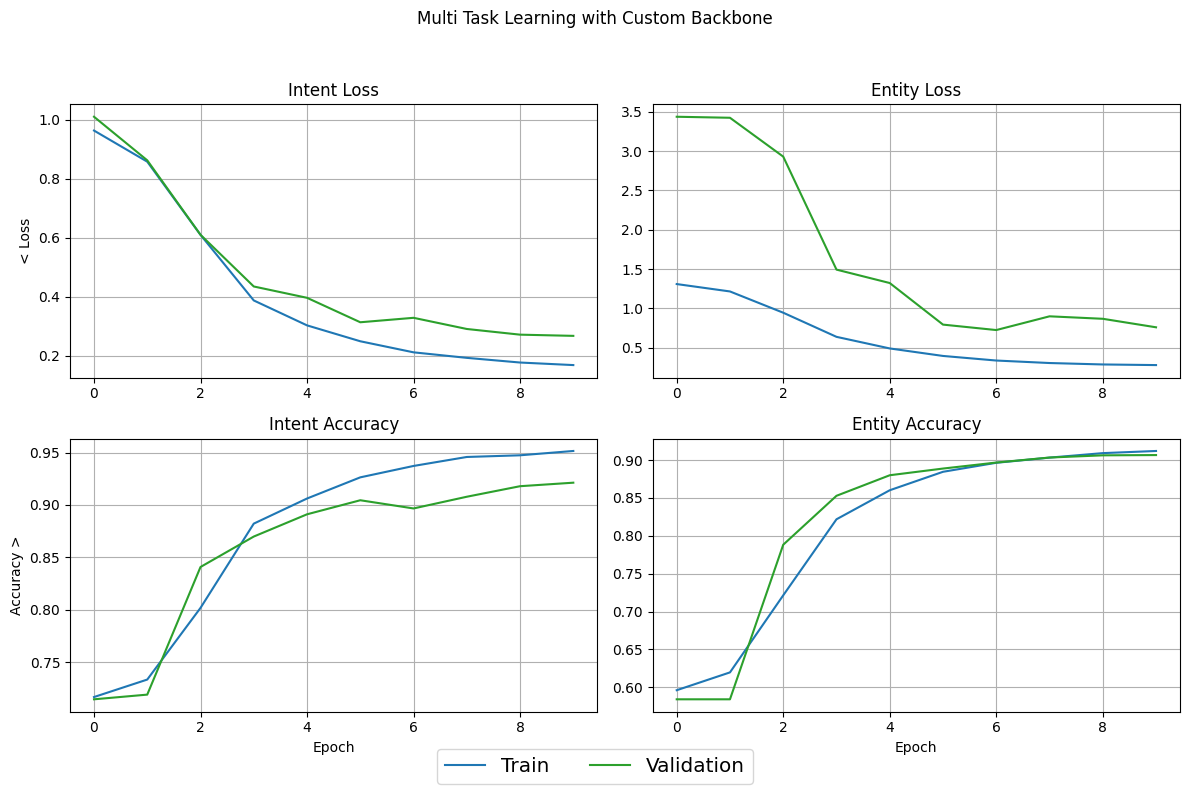

In [ ]:
encoder =  Encoder("custom", 768).to(device)
model = Model(encoder).to(device)
custom_metrics = train_model(train_ds, val_ds, model, epochs=EPOCHS)
plot_metrics(custom_metrics, "Multi Task Learning with Custom Backbone")

In [7]:
encoder = Encoder().to(device) # BERT pretrained
model   = Model(encoder).to(device)

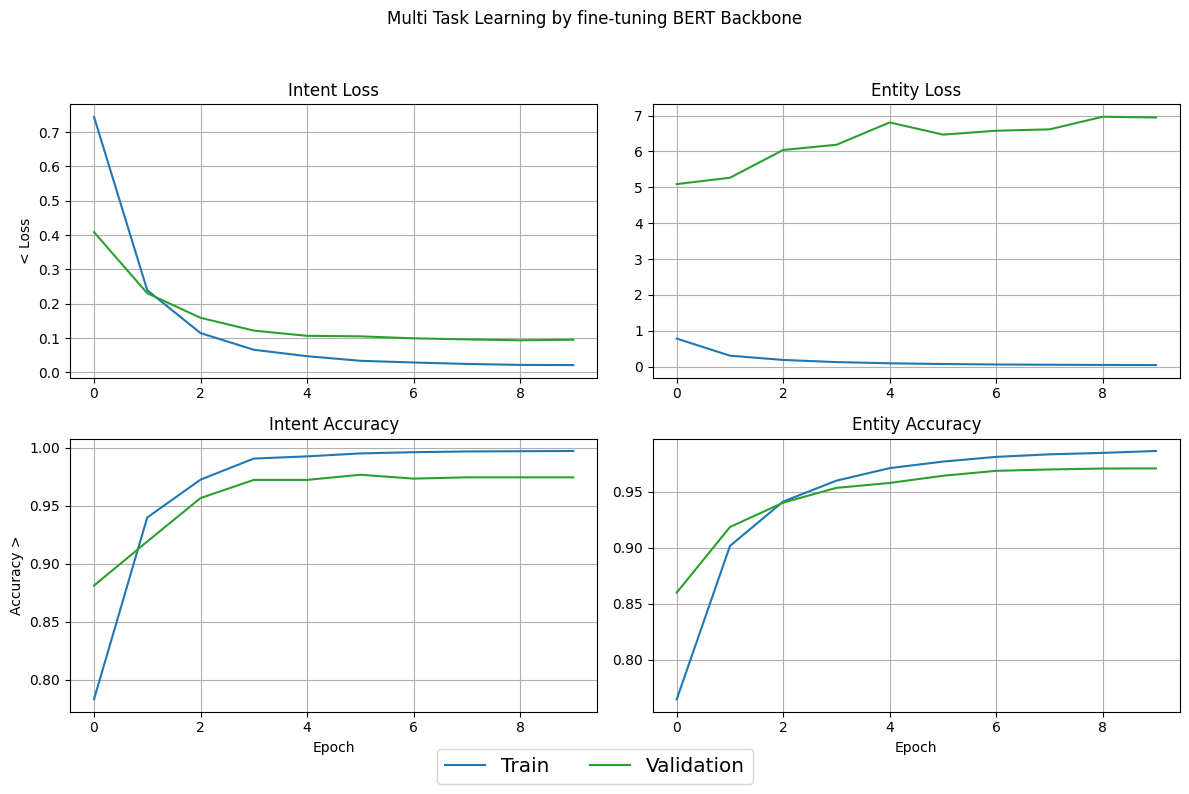

In [ ]:
ft_metrics = train_model(train_ds, val_ds, model, epochs=EPOCHS)
plot_metrics(ft_metrics, "Multi Task Learning by fine-tuning BERT Backbone")

In [9]:
encoder = Encoder().to(device) # BERT pretrained
model   = Model(encoder).to(device)

# freeze backbone
for param in model.encoder.backbone.parameters():
    param.requires_grad = False

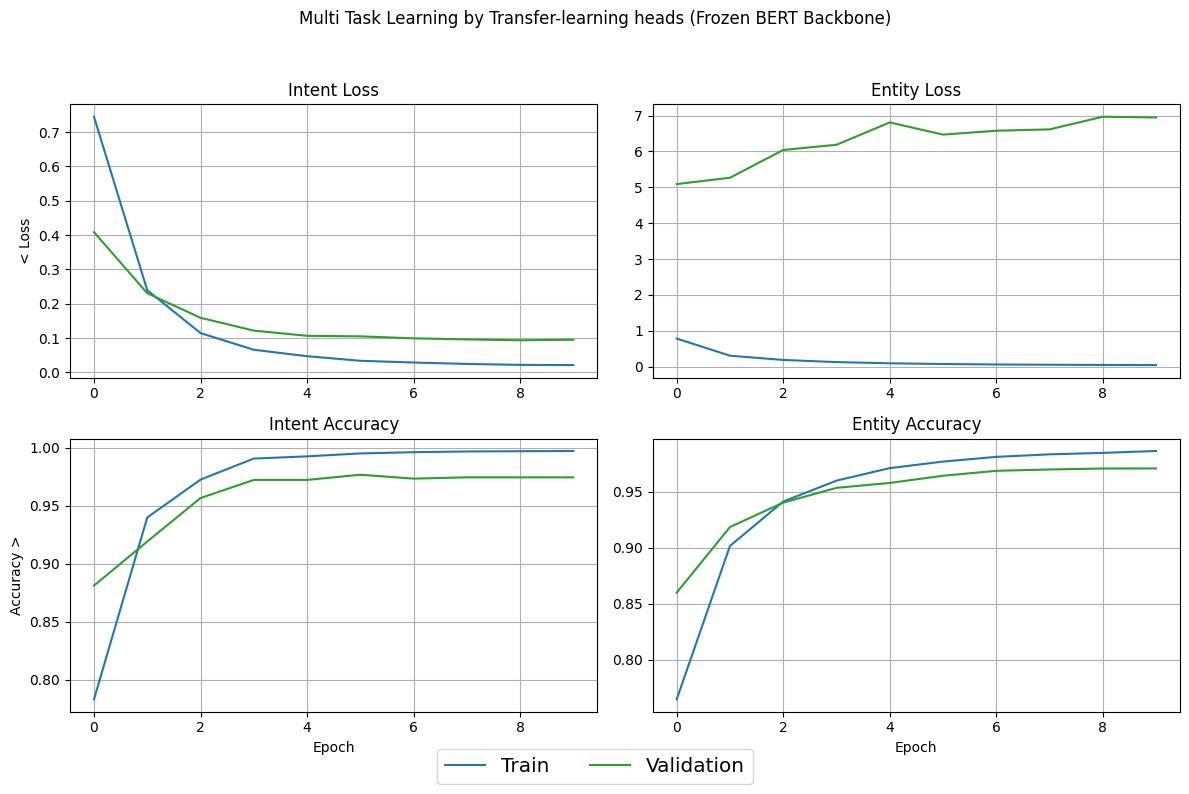

In [ ]:
tl_metrics = train_model(train_ds, val_ds, model, epochs=EPOCHS)
plot_metrics(ft_metrics, "Multi Task Learning by Transfer-learning heads (Frozen BERT Backbone)")

In [11]:
# encoder = Encoder().to(device) # BERT pretrained
# model   = Model(encoder).to(device)

# # reset paratemets 
# for p in model.parameters():
#     if p.dim() > 1:
#         torch.nn.init.xavier_uniform_(p)

In [12]:
# bert_training_metrics = train_model(train_ds, val_ds, model, epochs=EPOCHS)
# plot_metrics(bert_metrics, "Multi Task Learning with BERT SFT")

### Appendix B: Metrics 

In [16]:
metric = {"tl": tl_metrics, "ft": ft_metrics, "custom": custom_metrics}

data = []

for k, val in metric.items():
    df = pd.DataFrame(val)
    df.loc[:, f'{k}_loss'] = df.train_loss
    df.loc[:, f'{k}_acc']  = 0.3*df.train_intent_acc + 0.7*df.train_entity_f1
    
    data.append(df[[f'{k}_loss', f"{k}_acc"]])

data.insert(0, df[['epoch']])
metrics_df = pd.concat(data, axis=1)

print(metrics_df.round(2))


   epoch  tl_loss  tl_acc  ft_loss  ft_acc  custom_loss  custom_acc
0      0     1.43    0.49     0.77    0.77         1.21        0.63
1      1     1.07    0.68     0.29    0.91         1.11        0.65
2      2     0.91    0.78     0.17    0.95         0.84        0.75
3      3     0.81    0.80     0.11    0.97         0.56        0.84
4      4     0.75    0.81     0.08    0.98         0.43        0.87
5      5     0.70    0.81     0.06    0.98         0.35        0.90
6      6     0.68    0.82     0.05    0.99         0.30        0.91
7      7     0.66    0.82     0.04    0.99         0.27        0.92
8      8     0.65    0.82     0.04    0.99         0.25        0.92
9      9     0.64    0.82     0.04    0.99         0.25        0.92


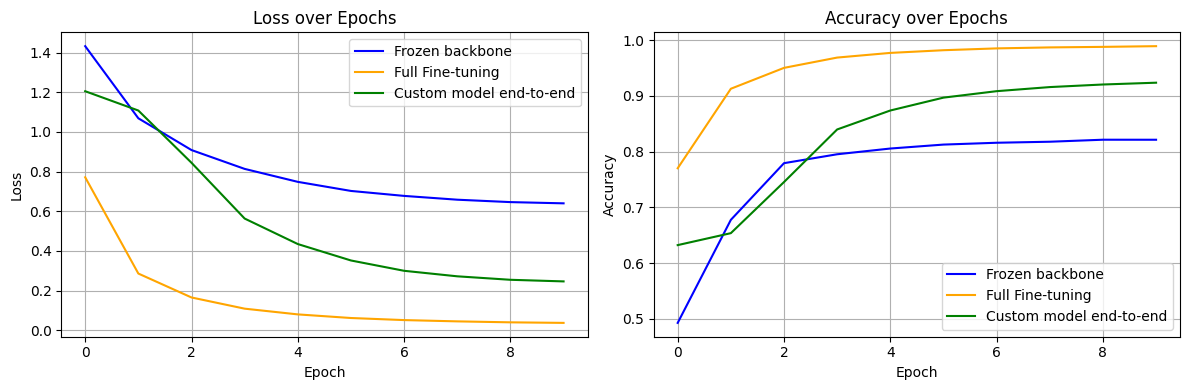

In [17]:
# Create side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
ax1.plot(metrics_df['epoch'], metrics_df['tl_loss'], label='Frozen backbone', color='blue')
ax1.plot(metrics_df['epoch'], metrics_df['ft_loss'], label='Full Fine-tuning', color='orange')
ax1.plot(metrics_df['epoch'], metrics_df['custom_loss'], label='Custom model end-to-end', color='green')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss over Epochs')
ax1.grid(True)
ax1.legend()

# Accuracy plot
ax2.plot(metrics_df['epoch'], metrics_df['tl_acc'], label='Frozen backbone', color='blue')
ax2.plot(metrics_df['epoch'], metrics_df['ft_acc'], label='Full Fine-tuning', color='orange')
ax2.plot(metrics_df['epoch'], metrics_df['custom_acc'], label='Custom model end-to-end', color='green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy over Epochs')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

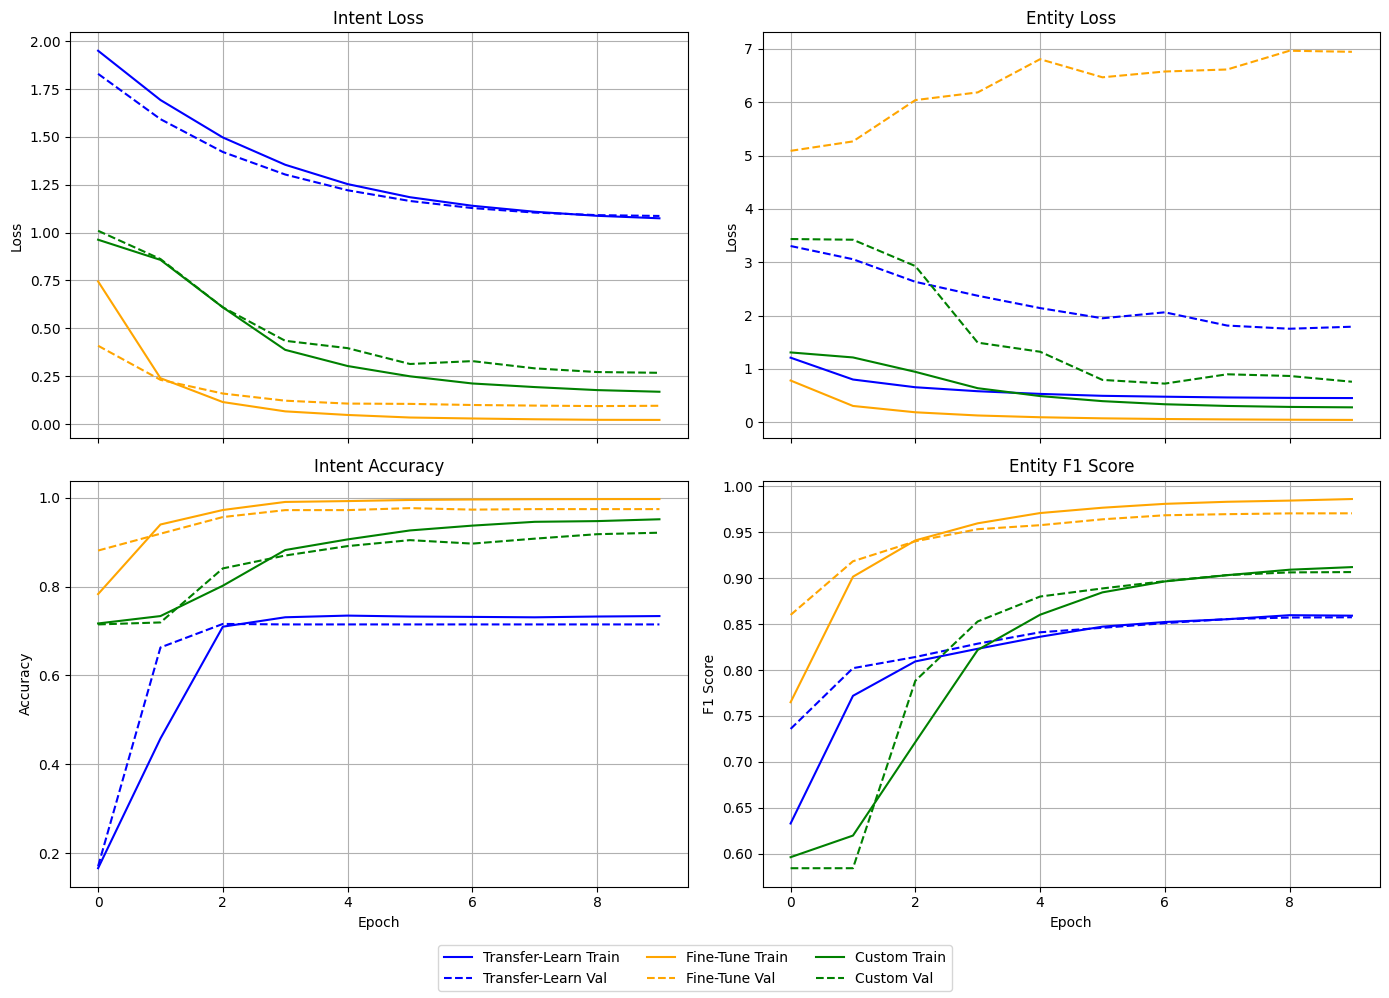

In [18]:
# more detailed view
plot_comparison_metrics_subplot(tl_metrics, ft_metrics, custom_metrics)